In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!mkdir dataset

In [ ]:
%%capture
!cd dataset
!unzip '/content/drive/MyDrive/Python Data/TSA/imdb_movie_review.zip' -d '/content/dataset'

In [ ]:
path_csv = '/content/dataset/IMDB Dataset.csv'

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(path_csv)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# we have to remove unwanted words and other characters to improve the
# model performace.


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import string

In [ ]:
stemmer = nltk.SnowballStemmer('english')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword = set(stopwords.words('english'))

In [ ]:
# Definig a Function to remove the unwanted words by using regex to search
# and replace it with ''
def clean_review(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [ ]:
df["review"] = df["review"].apply(clean_review)

In [ ]:
df.head()

,review,sentiment
0,one review mention watch oz episod youll hook...,positive
1,a wonder littl product the film techniqu unass...,positive
2,i thought wonder way spend time hot summer wee...,positive
3,basic there famili littl boy jake think there ...,negative
4,petter mattei love time money visual stun film...,positive


# Train and Test Data Split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
x = np.array(df['review'])
y = np.array(df['sentiment'])

In [ ]:
cv = CountVectorizer()
X = cv.fit_transform(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,
                                                    random_state=9)

In [ ]:
y_train = [1 if i == 'positive' else 0 for i in y_train]
y_test = [1 if i == 'positive' else 0 for i in y_test]

In [ ]:
import tensorflow as tf

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

# Vizulatizing Data

In [ ]:
X_train.shape

TensorShape([40000, 173770])

In [ ]:
X_test.shape

TensorShape([10000, 173770])

In [ ]:
y_train[:5]

[0, 1, 0, 1, 1]

In [ ]:
y_test[:5]

[0, 1, 1, 1, 0]

# Building Model

In [ ]:
import tensorflow as tf

In [ ]:
input_shape = (X_train.shape[1],)

In [ ]:
def build_model(input_shape):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape, batch_size=32))
  model.add(tf.keras.layers.Dense(units=100, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  opt = tf.keras.optimizers.Adam()
  model.compile(optimizer=opt,
                loss='BinaryCrossentropy',
                metrics=['accuracy'])

  model.summary()

  return model

In [ ]:
tsa_model = build_model(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 100)                 17377100  
                                                                 
 dropout (Dropout)           (32, 100)                 0         
                                                                 
 dense_1 (Dense)             (32, 1)                   101       
                                                                 
Total params: 17,377,201
Trainable params: 17,377,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                        'tsa_model.h5',
                        verbose=1,
                        save_best_only=True,
                        monitor='val_loss')

In [ ]:
# X_train, X_test, y_train, y_test

In [ ]:
history = tsa_model.fit(x=X_train,y= np.array(y_train),
              validation_data=(X_test, np.array(y_test)),
              epochs=1000,
              callbacks=[stop_early, checkpoint])

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1247/1250 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8754
Epoch 1: val_loss improved from inf to 0.27435, saving model to tsa_model.h5
1250/1250 [==============================] - 21s 14ms/step - loss: 0.3085 - accuracy: 0.8756 - val_loss: 0.2744 - val_accuracy: 0.8876
Epoch 2/1000
1248/1250 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9475
Epoch 2: val_loss did not improve from 0.27435
1250/1250 [==============================] - 17s 14ms/step - loss: 0.1329 - accuracy: 0.9474 - val_loss: 0.3238 - val_accuracy: 0.8840
Epoch 3/1000
1248/1250 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9828
Epoch 3: val_loss did not improve from 0.27435
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0500 - accuracy: 0.9828 - val_loss: 0.3904 - val_accuracy: 0.8790
Epoch 4/1000
1247/1250 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9957
Epoch 4: val_loss did not improve fro

In [ ]:
# 100X1, Dropout(0.2) - 89.23% # Final Model
# 100X1, Dropout(0.4) - 88.54%

In [ ]:
import matplotlib.pyplot as plt

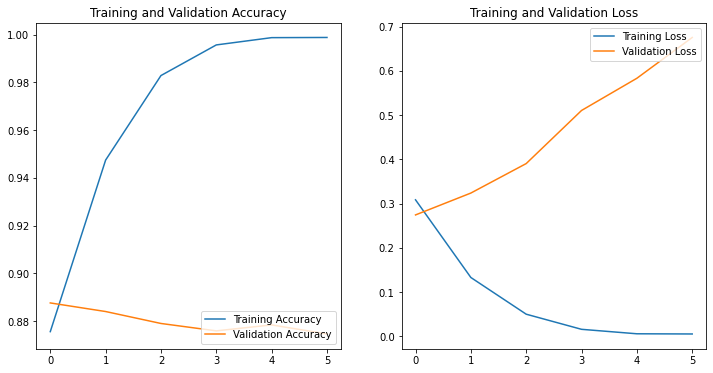

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(f'the Accuracy of the model is {max(val_acc)}')

the Accuracy of the model is 0.8876000046730042


# Data Augmentation

In [ ]:
!pip install textattack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 7.4 MB/s 
     |████████████████████████████████| 3.6 MB 50.6 MB/s 
     |████████████████████████████████| 365 kB 59.8 MB/s 
     |████████████████████████████████| 5.5 MB 54.4 MB/s 
     |████████████████████████████████| 41.4 MB 1.7 MB/s 
     |████████████████████████████████| 769 kB 53.5 MB/s 
     |████████████████████████████████| 401 kB 66.4 MB/s 
     |████████████████████████████████| 125 kB 70.9 MB/s 
     |████████████████████████████████| 60 kB 8.3 MB/s 
     |████████████████████████████████| 212 kB 56.9 MB/s 
     |████████████████████████████████| 163 kB 66.2 MB/s 
     |████████████████████████████████| 115 kB 73.7 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 127 kB 71.7 MB/s 
     |████████████████████████████████| 7.6 MB 47.0 MB/s 
     |██████████████████████████████

In [ ]:
from textattack.augmentation import WordNetAugmenter

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# %%capture
from textattack.augmentation import WordNetAugmenter

In [ ]:
wordnet_aug = WordNetAugmenter()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
new_review, new_sentiment = [] , []
for i in df.index:
  if i < 5:
    new_review.append(wordnet_aug.augment(df['review'].iloc[i]))

In [ ]:
new_review[1]

['a wonder littl product the film techniqu unassum oldtimebbc fashion present comfort sometim discomfort sens realism entir piec the actor extrem well chosen michael sheen sustain polari voic pat you truli see seamless edit guid refer william diari entri well worth watch terrif written perform piec a master product single peachy surmount comedi life the realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear it run knowledg sens particular scene concern orton halliwel limit particular unconditional halliwel mural decor everi surfac terribl well behave']

In [ ]:
df.review[1]

'a wonder littl product the film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec the actor extrem well chosen michael sheen got polari voic pat you truli see seamless edit guid refer william diari entri well worth watch terrif written perform piec a master product one great master comedi life the realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear it play knowledg sens particular scene concern orton halliwel set particular flat halliwel mural decor everi surfac terribl well done'

In [ ]:
df.sentiment[1]

'positive'

In [ ]:
a = cv.transform(new_review[1])
a = convert_sparse_matrix_to_sparse_tensor(a)
if tsa_model.predict(a)[0][0] == 1:
  print('positive')
else:
  print('negative')

1/1 [==============================] - 0s 112ms/step
positive


In [ ]:
# This shows that Using the above base code you can augment to generate new data
# which have synonyms of word of replaced words.
# above example is just to illustrate even after augmentation,
# The sentence is still positive.